In [1]:
import numpy as np
from scipy import stats, special
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm

from ipywidgets import interact
import ipywidgets as ipyw
from IPython.display import IFrame

In [2]:
az.style.use('arviz-darkgrid')

## Computing the posterior distribution

* There are many ways to compute a posterior
    * <font color=gray> Conjugacy </font>
    * Laplace Method
    * Grid method
    * <font color=gray> Integrated Laplace approximation (INLA)</font>
    * <font color=gray> Variational Inference (VI) </font>
    * Markov Chain Monte Carlo (MCMC)
    * ...


* Only MCMC methods (and to less extend VI) are general enough

## Laplace approximation

* Compute the Maximum a posteriori (the mode of the posterior). $\theta_{MAP}$

* Compute the Hessian Matrix $\mathcal{H}$

* Approximate the posterior as $\mathcal{N}\left(\theta_{MAP}, \mathcal{H}^{-0.5}\right)$

* Use the Hessian matrix to estimate the covariance of the Gaussian

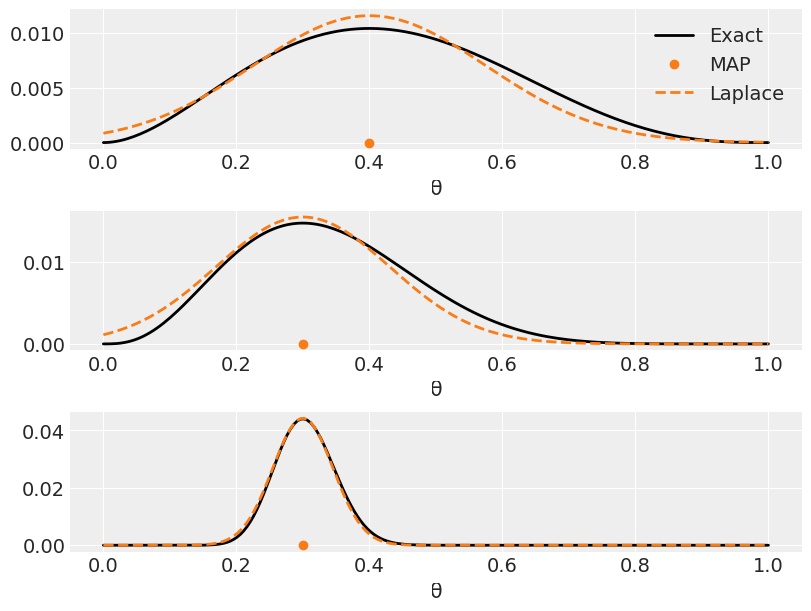

In [8]:
θ = np.linspace(0.0001, 0.9999, 200)
α = 1
β = 1

_, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(8, 6))

for i, (N1, N) in enumerate([(2, 5), (3, 10), (30, 100)]):
    N0 = N - N1
    θ_MAP =  (α + N1-1) / (α + β + N-2)
    var =  ((α + N1) * (β + N0)) / ((α + N1 + β + N0)**2 * (α + N1 + β + N0 + 1))
    std = var**0.5

    post1 = stats.binom(N, θ).pmf(N1) * stats.beta(α, β).pdf(θ)
    post1 = post1 / np.sum(post1)
    post2 = stats.norm(θ_MAP, std).pdf(θ)
    post2 /= post2.sum()

    ax[i].plot(θ, post1, 'k', lw=2, label='Exact')
    ax[i].plot(θ_MAP, 0, 'oC1', label='MAP')
    ax[i].plot(θ, post2, 'C1--', lw=2, label='Laplace')
    ax[i].set_xlabel('θ')
ax[0].legend();

In [9]:
def posterior_grid(grid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, grid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title('heads = {}\ntrials = {}'.format(heads, trials))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['prior', 'likelihood', 'posterior'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend(fontsize=14)


interact(posterior_grid, grid=ipyw.IntSlider(min=2, max=100, step=1, value=15), α=ipyw.FloatSlider(min=1, max=7, step=1, value=1), β=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), heads=ipyw.IntSlider(min=0, max=20, step=1, value=6), trials=ipyw.IntSlider(min=0, max=20, step=1, value=9));

interactive(children=(IntSlider(value=15, description='grid', min=2), FloatSlider(value=1.0, description='α', …

In [1]:
## Cadenas de Markov (CM)

## Markov Chain Monte Carlo (MCMC)

<br>

* MCMC methods can be used to **sample** from probability distributions that are difficult to sample directly


* If some mild conditions are satisfied, we get a theoretical guarantee that MCMC methods will _asymptotically_ converge to the correct stationary distribution. 


* Because we do not have guarantees for finite samples we need to diagnose the quality of the MCMC samples (we will discuss this later)

## The Metropolis-Hasting algorithm

1. Initialize the value of the parameter $x$ at $x_i$

2. Choose a new parameter value $x_{i + 1}$ , sampling from an easy-to-sample distribution such as a Gaussian distribution $q(x_{i + 1} \mid x_i)$. 

3. Compute the probability of accepting a new parameter value by using the Metropolis-Hastings criteria:

$$p_a (x_{i + 1} \mid x_i) = min \left (1, \frac{p(x_{i + 1}) q(x_i \mid x_{i + 1})} {p(x_i) q (x_{i + 1} \mid x_i} \right)$$

4. If $p_a \gt r$ where $r \sim \mathcal{U}(0, 1)$. Accept the new state, otherwise stay in the old state

5. Iterate from 2 until getting _enough_ samples


In [10]:
def log_post(θ, Y, α=1, β=1):
    """
    Compute log posterior distribution for the model:
    
    Beta(α, β) prior
    Y ~ Bern(θ) likelihood
    """
    prior = stats.beta(α, β).logpdf(θ)
    like  = stats.bernoulli(θ).logpmf(Y).sum()
    return like + prior

In [11]:
np.random.seed(820)
data = stats.bernoulli(0.1).rvs(50)

In [12]:
# This is pedagogical example and not production code
# computation are in log scale for numerical stability
n_iters = 1000
proposal_sd = 0.1  # Try different values of can_sd to see the effect on the acceptance rate

# initial values
θ = 0
results = np.zeros(n_iters)
# precompute values for later use
Δ = stats.norm(0, proposal_sd).rvs(n_iters)
rnd = np.log(stats.uniform().rvs(n_iters))

for iter in range(n_iters):
    # Draw a candidate by perturbing current state
    candidate = θ + Δ[iter]
    new_p = log_post(candidate, data)
    old_p = log_post(θ, data)
    R = new_p - old_p
    # acceptance criterion
    if R > rnd[iter]:
        θ = candidate

    results[iter] = θ

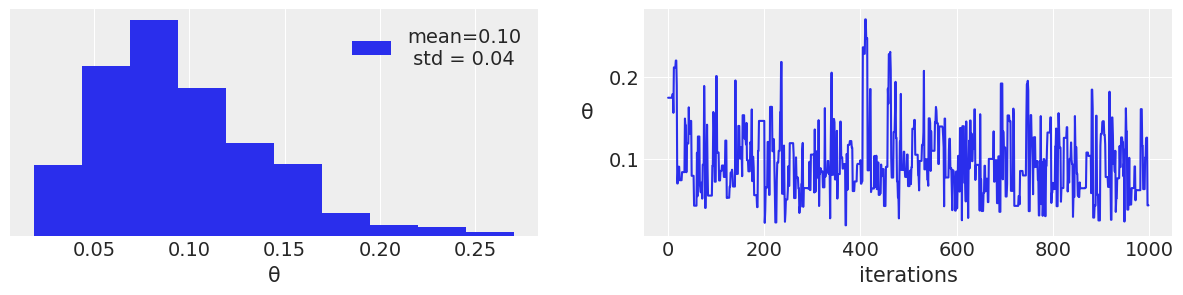

In [54]:
_, ax = plt.subplots(1, 2, figsize=(15, 3))
mean = results.mean()
std = results.std()
ax[0].hist(results, density=True, label=f'mean={mean:.2f}\n std = {std:.2f}')
ax[0].set_xlabel('θ')
ax[0].set_yticks([])
ax[0].legend()
ax[1].plot(results)
ax[1].set_ylabel('θ', rotation=0, labelpad=15)
ax[1].set_xlabel('iterations');

In [35]:
az.summary(samples)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 990), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.096,0.042,0.025,0.163,0.003,0.002,218.0,187.0,250.0,167.0,NaN


### The Efficiency of MH

* In practice MH has to be tuned for particular problems
* The proposal distribution is extremely import to get a useful implementation of the algorithm
* This can be done automatically (adaptative MH)
* The covariance matrix of the proposal distribution is _tuned_ to reach a target acceptance ratio of 0.234 (or _close_ to it)

## Hamiltonian Monte Carlo (HMC) and NUTS

* HMC is an extension of MH where the proposal distribution comes from Hamiltonian evolution of a _particle following the potential energy (posterior distribution) and the momentum (auxiliary variable).
* Compared to MH the efficiency is significantly increased because the correlation between successive samples is reduced 
* This is a direct consequence of the ability of the method to propose new states with high acceptance rate even when they are distant in the parameter space. 
* The efficiency of the HMC heavily depends on certain hyperparameters
* NUTS is a HMC method that automatically computes such hyperparameters

[HMC from scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)

Si quieren puedo incluir código para el computo de un HMC, pero me parece que explicar el método (para que se entienda el código) 
puede llevar mucho tiempo. Si nos queremos quedar con lo intuitivo, creo que bastaría con jugar un poco con el ejemplo a continaución, donde se pueden ver comp funcionan varios samplers para varias distribuciones.

In [36]:
IFrame(src='mcmc-demo-master/app.html#RandomWalkMH,standard', width=1200, height=600)

## Bayesian statistics in a nutshell

* Models produce data
* Models has unknown parameters
* We associate prior probability distributions to parameters
* Bayes' theorem allow us to combine data and the prior distribution
* The posterior is the joint distribution of parameters after seen the data
* Hopefully the posterior distribution will have less uncertainty than the prior distribution

# Exercises


1. Starting from the definition of conditional probability $p(A \mid B) = \frac{p(A, B)}{p(B)}$ obtain Bayes' theorem

2. 

3. Use the following interactive widget to explore different combinations of priors and likelihoods. Summarize the observations that you consider most relevant.